In [1]:
# <!--------------------------------------------------------------------------->
# <!--                    KU - University of Copenhagen                      -->
# <!--                          Faculty of Science                           -->
# <!--                Vision and Image Processing (VIP) Course               -->
# <!-- File       : main.ipynb                                               -->
# <!-- Description: Feature matching and image stitching                     -->
# <!-- Author     : Wengguang Zheng, Weisi Li                                -->
# <!--------------------------------------------------------------------------->

__version__ = "$Revision: 2020010401 $"


In [2]:
import numpy as np  
import matplotlib.pyplot as plt  
import cv2
# np.set_printoptions(threshold=np.nan)
import sklearn.preprocessing
import random

In [3]:
def get_harris_position(img,k = 0.04,threshold = 0.01):
    dst = cv2.cornerHarris(img,2,3,k)
    dst = cv2.dilate(dst,None)
    ret, dst = cv2.threshold(dst,threshold*dst.max(),255,0)
    dst = np.uint8(dst)

    #find centroids
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

    #define the criteria to stop and refine the corners
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    corners = cv2.cornerSubPix(img,np.float32(centroids),(5,5),(-1,-1),criteria)
    #here u can get corners
    return corners

def show_corner(img,corners):
    fig, ax = plt.subplots()  # show corners
    ax.imshow(img, cmap=plt.cm.gray)
    ax.plot(corners[:, 0], corners[:, 1], '.b', markersize=8)
    plt.title('Harris Detection')
    plt.show()


In [4]:
# to calculate single patch
def extract_patch(img, corner,n):
    x = int(corner[0]) 
    y = int(corner[1]) 
    size_n = int(n/2)
    # #print(size_n)
    # new_corner = [x,y]
    window = img[(x-size_n):(x+size_n+1), (y-size_n):(y+size_n+1)]
   # print(window)
    return  window 

# to take patches
def get_patch(corners,replicate_img,n):
    windows = []
    
    #print(np.shape(corners),np.shape(corners))
    # corners = corners2
    for each_corner in corners:
        window = extract_patch(replicate_img,each_corner,n)
        # print(window)
        if len(window)>0 and window.shape == (n+1,n+1):
            window = sklearn.preprocessing.normalize(window)
            windows.append(window)
        # new_corners.append(new_corner)
        # #print("windows1",np.shape(windows1))
    return windows


In [5]:
# to calculate SSD and apply ratio to calculate the first_match
def ssd(p1,p2,new_corners1,new_corners2,r=0.8):
    similarity1 = [0,0]
    similarity2 = [0,0]
    match = []
    locations_A = []
    locations_B = []
    for each_p1,each_location1 in zip(p1,new_corners1):
        for i, (each_p2,each_location2) in enumerate(zip(p2,new_corners2)):
            # print(i, each_p2,each_location2)
            p1_sub_p2 = np.subtract(each_p1,each_p2)
            p1p2square = np.power(p1_sub_p2,2)
            score = np.power(np.sum(p1p2square),0.5)
            # print("score",score)

            if i == 0:
                similarity1 = [score,i]
                similarity2 = [score,i]

            if score < similarity1[0]:
                similarity1 = [score,i]
            elif score < similarity2[0]:
                similarity2 = [score,i]
        
            # print("np",np.amin(copied_sim,0)) 
            # sorted_sim = sorted(similarity)
            # print("sorted",sorted_sim[0][0],sorted_sim[0][1])
        # print(similarity1,similarity2)
        if similarity1[0] < r * similarity2[0]:
        	# print(sorted_sim,sorted_sim[0][0],sorted_sim[1][0])
        	match.append([each_p1,p2[similarity1[1]]])
        	# print("match",match)
        	# location.append([each_location1,new_corners2[sorted_sim[0][1]]])
        	locations_A.append(each_location1)
        	locations_B.append(new_corners2[similarity1[1]])
        	# print("locations",type(location),np.shape(location))
    # print("locations_A",locations_A,"locations_B",locations_B,"match",len(match))
    return match,locations_A,locations_B

def ssdstat(matches):
    totals = []
    for each_array1 in matches:
        total = np.subtract(each_array1[0:1], each_array1[1:2])
        total = np.power(total, 2)
        total = np.power(np.sum(total), 0.5)
        totals.append(total)
    return totals


In [8]:
# def eliminateMultiCorrespondence(match_AtoB,match_BtoA):
#     match3 = []
#     for each_array1 in match_AtoB:
#         for each_array2 in match_BtoA:
#             # print("each",each_array1,np.shape(each_array1))
#             if np.array_equal(each_array1[0:1:1], each_array2[1:2]) and np.array_equal(each_array2[0:1:1], each_array1[1:2]):
#                 match3.append([each_array1,each_array2])
#                 # match3[each_array1] = each_array2
#                 # print("match3",match3)
#     return match3

def eliminateMultiCorrespondence(match_AtoB,match_BtoA,locations_A,locations_B,locations_2A,locations_2B):
    match3 = []
    match_locations1 = []
    match_locations2 = []
    for each_array1, l_A, l_B in zip(match_AtoB,locations_A,locations_B):
        for each_array2 in match_BtoA:
            # print("each",each_array1,np.shape(each_array1))
            if np.array_equal(each_array1[0:1:1], each_array2[1:2]) and np.array_equal(each_array2[0:1:1], each_array1[1:2]):
                match3.append([each_array1,each_array2])
                match_locations1.append(l_A)
                match_locations2.append(l_B)
                # match3[each_array1] = each_array2
                # print("match3",match3)
    return match3,match_locations1,match_locations2

def findLocations(matches,patches1,locations1,patches2,locations2):
    match_locations1 = []
    match_locations2 = []
    for each_patch1, each_location1,each_patch2,each_location2 in zip(patches1,locations1,patches2,locations2):
        # print("each_patch,each_location",each_patch,each_location)
        for each_match1 in matches[0]:
            # print("each_match",each_match,"matches",matches)
            if np.array_equal(each_match1[0:1:1][0],each_patch1):
                match_locations1.append(each_location1)
                match_locations2.append(each_location2)
    return match_locations1,match_locations2

In [9]:
def to_kpt(pt,size=1):
	return cv2.KeyPoint(pt[0],pt[1],size)

def stitch_imgs(img1, img2):
    """
    img1 and img2 can be the same
    """
    double_img = np.concatenate((img1, img2), axis = 1)
    return double_img 

In [25]:
def draw_lines(img, list_of_a_coords, list_of_b_coords, color = (0,255,0), thickness = 2):
    width = int(img.shape[1]/2)
    for A_coord, B_coord in zip(list_of_a_coords, list_of_b_coords):
        cv2.line(img, (int(A_coord[0]),int(A_coord[1])),((int(B_coord[0])+width),int(B_coord[1])),color,thickness)
    return img

In [6]:
# MAIN
#----------- LOAD ---------#
img1_origin = cv2.imread('./inputs/im1red.png')
img2_origin = cv2.imread('./inputs/im2red.png')

img1 = cv2.cvtColor(img1_origin, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_origin, cv2.COLOR_BGR2GRAY)

The patch size 10


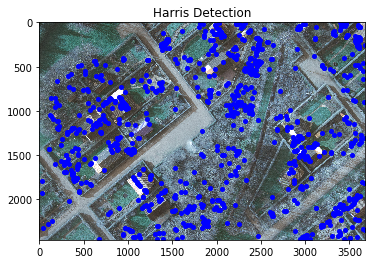

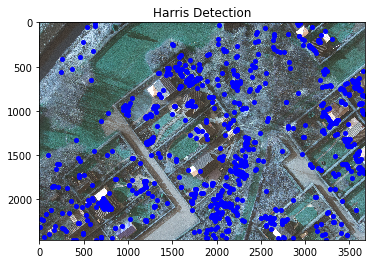

In [7]:
#----------- 1.Detecting interest points ---------#
#print(type(img1),img1,np.shape(img1))
corners1 = get_harris_position(img1,threshold = 0.1)
corners2 = get_harris_position(img2,threshold = 0.1)

show_corner(img1_origin,corners1)
show_corner(img2_origin,corners2)
#----------- 1.Detecting interest points ---------#

In [11]:
#--------- 2.Feature matching -----------#

replicate_img1 = cv2.copyMakeBorder(img1,30,30,30,30,cv2.BORDER_REPLICATE)
replicate_img2 = cv2.copyMakeBorder(img2,30,30,30,30,cv2.BORDER_REPLICATE)

#----- 2.1 For each extracted point you attribute a descriptor ------#
# Get windows
# Side length
n = 10 #(the patch size, between 3-31, odd)
# Test it one by one! 
print("The patch size",n)
patches1 = get_patch(corners1,replicate_img1,n)
patches2 = get_patch(corners2,replicate_img2,n)

#----- 2.1 select matches as the pair of interest points that have most similar descriptors ----#

#(the ratio between best match and the second match)
# for r in [0.95,0.9,0.85,0.8,0.75,0.7,0.65,0.6]:
# Test it one by one! 
r = 0.95
match_AtoB,locations_A,locations_B= ssd(patches1,patches2,corners1,corners2,r)
match_BtoA,locations_2A,locations_2B= ssd(patches2,patches1,corners2,corners1,r)

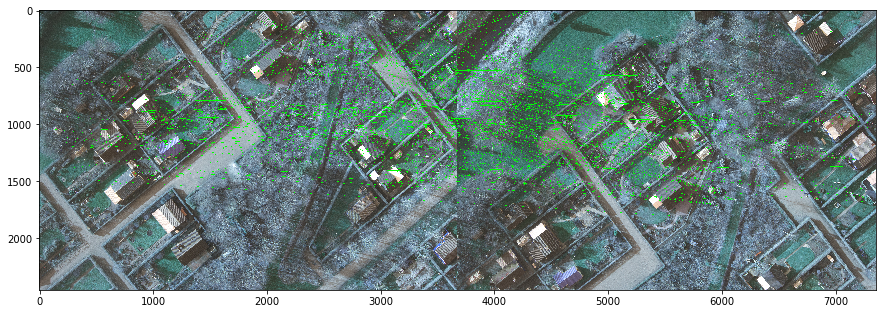

In [19]:
# Show One to More AtoB results(for report)
combined_img = stitch_imgs(img1_origin,img2_origin)
img_AtoB = draw_lines(combined_img, locations_A, locations_B)
plt.figure(figsize=(15, 7))
plt.imshow(img_AtoB,plt.cm.gray)
plt.show()

In [ ]:
# Show One to More BtoA results(for report)
combined_img = stitch_imgs(img1_origin,img2_origin)
img_BtoA = draw_lines(combined_img, locations_2A, locations_2B)
plt.figure(figsize=(15, 7))
plt.imshow(img_BtoA,plt.cm.gray)
plt.show()

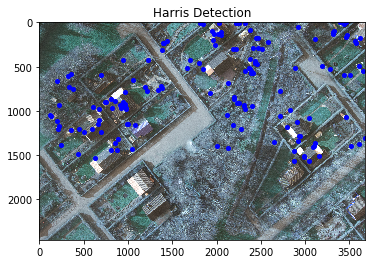

In [20]:
show_corner(img1_origin,np.array(locations_A))

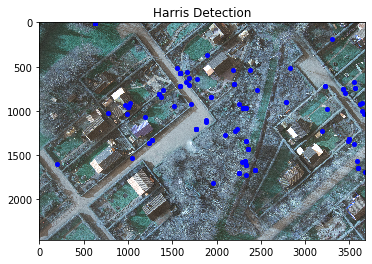

In [21]:
show_corner(img1_origin,np.array(locations_B))

In [22]:
match_final,match_locations1,match_locations2 = eliminateMultiCorrespondence(match_AtoB,match_BtoA,locations_A,locations_B,locations_2A,locations_2B)
# print("match_final",match_final)
# keypoint1 = to_kpt(a for a in locations_A)
# keypoint2 = to_kpt(b for b in locations_B)
# print(keypoint1,keypoint2)
# img3 = cv2.drawMatches(replicate_img1,keypoint1,replicate_img2,keypoint2,None,match_AtoB[:10],flags = 2)
# plt.plot(img3)
# print("matches",len(match_AtoB))
total = ssdstat(match_AtoB)
print(len(total))
print("std",np.std(total))
print("mean",np.mean(total))

153
std 0.18372552227687766
mean 0.37305458008128467


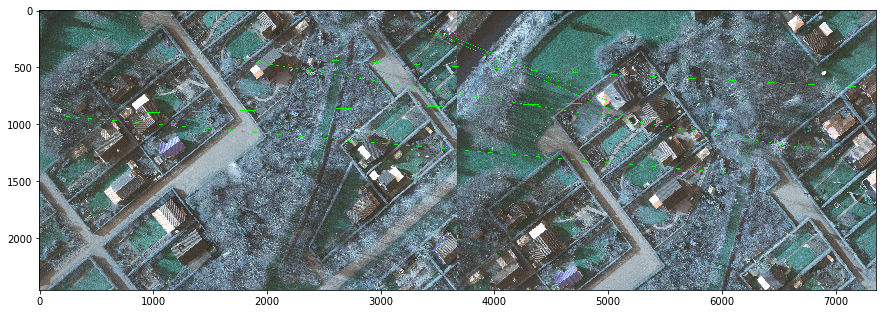

In [26]:
# match_locations1,match_locations2 = findLocations(match_final,patches1,locations_A,patches2,locations_B)
# match_locations2 = findLocations(match_final,patches2,new_corners2)
# print("match_locations",match_locations1,match_locations2)

combined_img = stitch_imgs(img1_origin,img2_origin)
plt.figure(figsize=(15, 7))
img4 = draw_lines(combined_img, match_locations1, match_locations2)
plt.imshow(img4,plt.cm.gray)
plt.show()